In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from time import time

from wavenet.utils import make_batch
from wavenet.models import Model, Generator

In [2]:
# 153 days and 96 customer aggregate groups
aggr50k = pd.read_csv('/home/aorhon/Downloads/LADWP_50k.csv').as_matrix()[1:,1:]
print(aggr50k.shape)

(153, 96)


In [3]:
def normalize(data):
    temp = np.float32(data) - np.min(data)
    out = ( temp / np.max(temp) - 0.5 ) *2
    return out

def quantize(timeseries, concat=False):
    
    if concat:
        tail2tail = []
        for series in range(timeseries.shape[0]):
            day = np.squeeze(timeseries[series,:])
            #day[day==0] = np.median(day)
            tail2tail.append(day)
        tail2tail = np.concatenate(tail2tail)
        timeseries = tail2tail
    
    data_ = normalize(timeseries)
    bins = np.linspace(-1, 1, 256)
    # Quantize inputs
    inputs = np.digitize(data_[0:-1], bins, right=False) - 1
    inputs = bins[inputs][None, :, None]

    # Encode targets as ints
    targets = (np.digitize(data_[1::], bins, right=False) - 1)[None, :]
    return inputs, targets



<IPython.core.display.Javascript object>


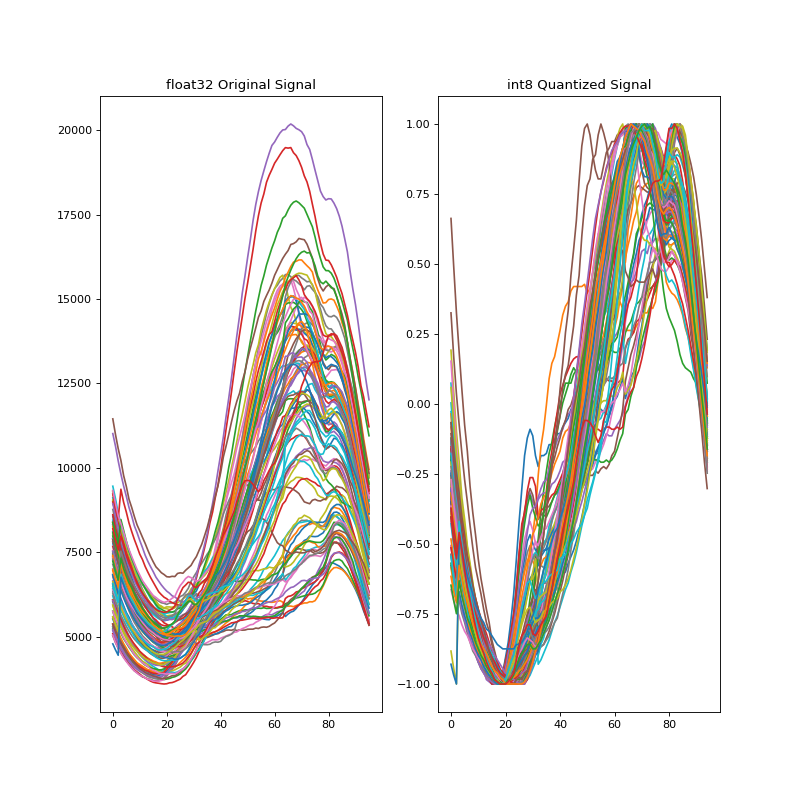

In [7]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

for cid in range(aggr50k.shape[1]):
    inputs, targets = quantize(aggr50k[cid,:])
    if(np.amin(aggr50k[cid,:])>1):
        ax[0].plot(np.squeeze(aggr50k[cid,:]))
        ax[1].plot(np.squeeze(inputs))

ax[0].set_title('float32 Original Signal')
ax[1].set_title('int8 Quantized Signal')
plt.show()

14591


<IPython.core.display.Javascript object>


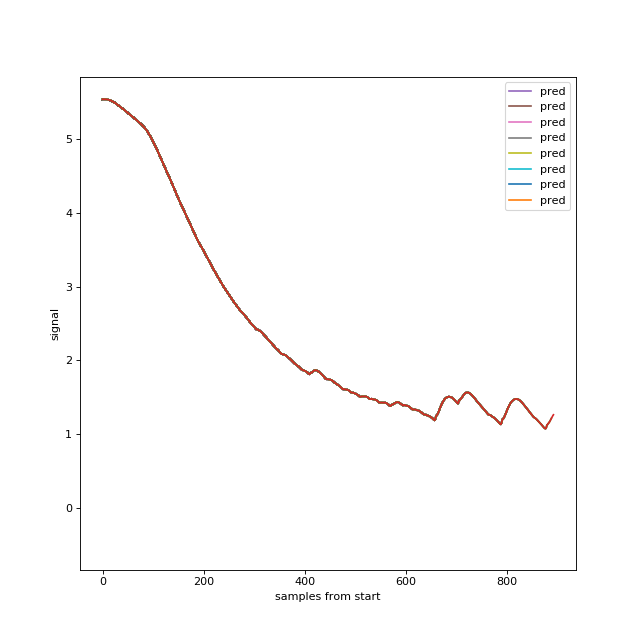

100%|██████████| 896/896 [01:03<00:00, 14.07it/s]

Training took 63.7008569241 seconds.


In [8]:
inputs, targets = quantize(aggr50k,concat=True)
test_holdout = inputs[:,:96,:]
inputs = inputs[:,96:,:] 
targets = targets[:,96:] 

num_time_samples = inputs.shape[1]
print(num_time_samples)
num_channels = 1
gpu_fraction = 1.0

model = Model(num_time_samples=num_time_samples,
              num_channels=num_channels,
              gpu_fraction=gpu_fraction)

tic = time()
model.train(inputs, targets)
toc = time()

print('Training took {} seconds.'.format(toc-tic))

Make Generator.
(1, 1)
Generating took 0.196318149567 seconds.


<IPython.core.display.Javascript object>


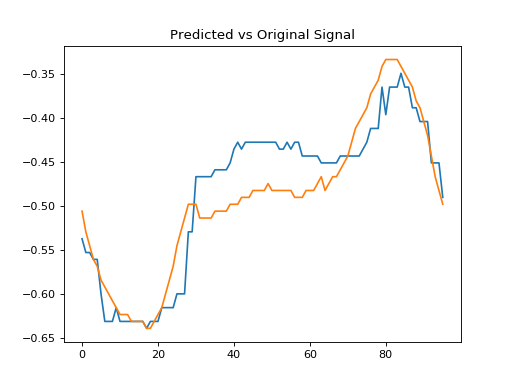

In [30]:
generator = Generator(model)

# Get first sample of input
input_ = test_holdout[:, 0:1, 0]
print(input_.shape)

tic = time()
predictions = generator.run(input_, 96)
toc = time()
print('Generating took {} seconds.'.format(toc-tic))

f, ax = plt.subplots()
ax.plot(np.squeeze(predictions))
ax.plot(np.squeeze(test_holdout))
ax.set_title('Predicted vs Original Signal')
plt.show()